In [1]:
from torch_snippets import *
from torchvision.utils import make_grid
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = MNIST('../AutoEncoders', train=True, download=False, transform=transform)

In [3]:
img, label = dataset[0]
img.min(), img.max()

(tensor(-1.), tensor(1.))

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, 
                                         drop_last = True)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.model(x)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    def forward(self, x): return self.model(x)

In [7]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [8]:
def generate_noise(size,dim=100):
    n = torch.randn(size,dim)
    return n.to(device)

In [9]:
def train_discriminator(discriminator, real_data, fake_data, 
                        loss_fn, optimizer):
    optimizer.zero_grad()
    pred_real = discriminator(real_data)
    loss_real = loss_fn(pred_real, torch.ones(len(real_data),1).to(device))
    loss_real.backward()
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake, torch.zeros(len(fake_data),1).to(device))
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [10]:
def train_generator(discriminator, fake_data, loss_fn, optimizer):
    optimizer.zero_grad()
    pred = discriminator(fake_data)
    loss = loss_fn(pred, torch.ones(len(fake_data),1).to(device))
    loss.backward()
    optimizer.step()
    return loss

In [12]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-4)
loss_fn = nn.BCELoss()
num_epochs=200
log = Report(num_epochs)

EPOCH: 20.000  d_loss: 0.731  g_loss: 2.065  (133.00s - 1197.01s remaining)
EPOCH: 40.000  d_loss: 0.988  g_loss: 1.458  (265.26s - 1061.03s remaining)
EPOCH: 60.000  d_loss: 1.116  g_loss: 1.185  (396.51s - 925.20s remaining))
EPOCH: 80.000  d_loss: 1.202  g_loss: 1.016  (524.70s - 787.05s remaining)
EPOCH: 100.000  d_loss: 1.218  g_loss: 0.998  (649.81s - 649.81s remaining)
EPOCH: 120.000  d_loss: 1.246  g_loss: 0.945  (777.18s - 518.12s remaining)
EPOCH: 140.000  d_loss: 1.252  g_loss: 0.930  (903.78s - 387.33s remaining)
EPOCH: 160.000  d_loss: 1.278  g_loss: 0.887  (1030.88s - 257.72s remaining)
EPOCH: 180.000  d_loss: 1.277  g_loss: 0.900  (1158.32s - 128.70s remaining)
EPOCH: 200.000  d_loss: 1.271  g_loss: 0.905  (1284.59s - 0.00s remaining)))


100%|██████████| 301/301 [00:03<00:00, 86.38it/s] 


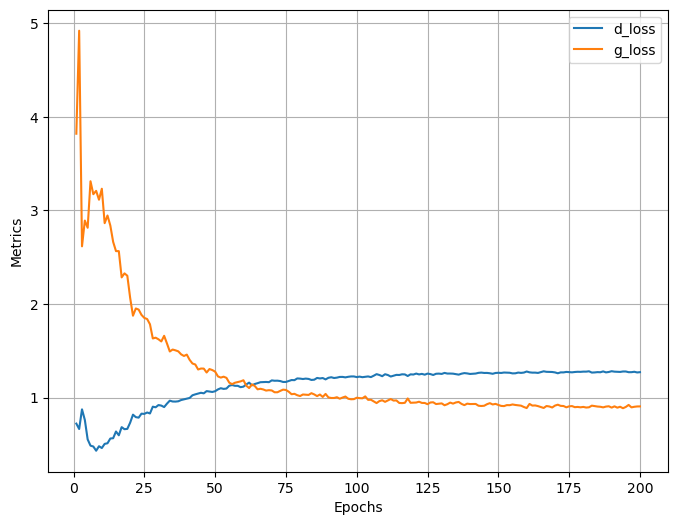

In [13]:
N = len(dataloader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        real_data = images.view(len(images),-1).to(device)
        fake_data = generator(generate_noise(len(real_data))).to(device)
        fake_data = fake_data.detach()
        d_loss = train_discriminator(discriminator,real_data,
                                     fake_data,loss_fn,d_optimizer)
        fake_data = generator(generate_noise(len(real_data))).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, 
                   d_loss=d_loss.item(),g_loss=g_loss.item(),end='\r')
    if (epoch+1) % 20 == 0:
        log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

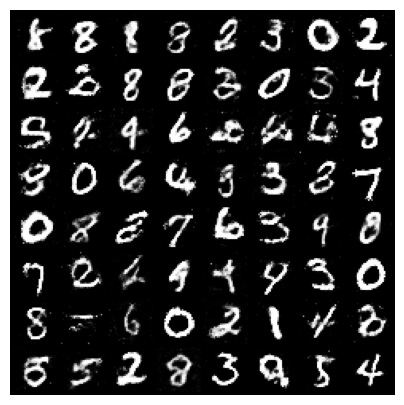

In [14]:
z = torch.randn(64,100).to(device)
generated_image = generator(z).data.cpu().view(64,1,28,28)
grid = make_grid(generated_image, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=5)